In [7]:
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/syttpz/Finance-Economics-Time-Series-Analysis/refs/heads/main/finance_economics_dataset.csv'

df = pd.read_csv(url)

df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('\ufeff', '')  # remove BOM if present
df.columns = df.columns.str.title()                # e.g., "date" → "Date"

print("\n✅ Cleaned column names:")
print(df.columns.tolist())



✅ Cleaned column names:
['Date', 'Stock Index', 'Open Price', 'Close Price', 'Daily High', 'Daily Low', 'Trading Volume', 'Gdp Growth (%)', 'Inflation Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)', 'Consumer Confidence Index', 'Government Debt (Billion Usd)', 'Corporate Profits (Billion Usd)', 'Forex Usd/Eur', 'Forex Usd/Jpy', 'Crude Oil Price (Usd Per Barrel)', 'Gold Price (Usd Per Ounce)', 'Real Estate Index', 'Retail Sales (Billion Usd)', 'Bankruptcy Rate (%)', 'Mergers & Acquisitions Deals', 'Venture Capital Funding (Billion Usd)', 'Consumer Spending (Billion Usd)']


In [8]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    print("\n✅ Date column converted and set as index.")
else:
    print("\n⚠️ 'Date' column not found after cleaning! Check column names above.")


✅ Date column converted and set as index.


In [10]:
if not isinstance(df.index, pd.DatetimeIndex):
    print("⚠️ Date is not yet set as datetime index. Please run the Date conversion step first.")
else:
    print("✅ Date is a valid datetime index.")

    print("\n🗓️ Date range:")
    print(f"From {df.index.min().date()} to {df.index.max().date()}")
    print(f"Total data points: {len(df)}")

    delta = df.index.to_series().diff().median()
    print(f"\n⏱️ Median time interval between records: {delta}")

    inferred_freq = pd.infer_freq(df.index)
    print(f"\n📅 Inferred frequency: {inferred_freq}")

✅ Date is a valid datetime index.

🗓️ Date range:
From 2000-01-01 to 2008-03-18
Total data points: 3000

⏱️ Median time interval between records: 1 days 00:00:00

📅 Inferred frequency: D


In [15]:
# --- 1) Define aggregation rules for monthly resampling -----------------------------------------
import re
import numpy as np
import pandas as pd

def pick_agg(col: str):
    c = col.lower()

    # Prices / indices → use last value of the month
    if any(k in c for k in [
        'close price', 'stock index', 'index', 'price', 'forex', 'gdp deflator'
    ]):
        return 'last'

    # High / Low → max or min of the month
    if 'high' in c: 
        return 'max'
    if 'low' in c:
        return 'min'

    # Open price → use first value of the month
    if 'open price' in c:
        return 'first'

    # Volume or deal count → sum for the month
    if any(k in c for k in ['volume', 'deals']):
        return 'sum'

    # Funding / sales / debt / profit / spending → sum for the month
    if any(k in c for k in [
        'funding', 'spending', 'sales', 'debt', 'profits', 'revenue'
    ]):
        return 'sum'

    # Percentages, rates, confidence index → average for the month
    if any(k in c for k in [
        '(%)', 'rate', 'yield', 'confidence'
    ]):
        return 'mean'

    # Default rule: mean
    return 'mean'


def build_agg_map(df: pd.DataFrame):
    agg = {}
    for col in df.columns:
        # Skip non-numeric columns
        if not np.issubdtype(df[col].dtype, np.number):
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except Exception:
                continue
        agg[col] = pick_agg(col)
    return agg

In [16]:
# --- 2) Resample daily data to monthly frequency (Month Start) -----------------------------------
df = df.sort_index()

# Fill missing values forward (to handle holidays or missing business days)
df_ffill = df.ffill()

agg_map = build_agg_map(df_ffill)
monthly = df_ffill.resample('MS').agg(agg_map)

# Forward fill again to clean up any missing monthly values
monthly = monthly.ffill()

print("✅ Monthly data ready:", monthly.index.min().date(), "→", monthly.index.max().date())
print("Number of months:", len(monthly))
print("Example aggregation rules (first 15 columns):")
list(agg_map.items())[:15]

✅ Monthly data ready: 2000-01-01 → 2008-03-01
Number of months: 99
Example aggregation rules (first 15 columns):


[('Stock Index', 'last'),
 ('Open Price', 'last'),
 ('Close Price', 'last'),
 ('Daily High', 'max'),
 ('Daily Low', 'min'),
 ('Trading Volume', 'sum'),
 ('Gdp Growth (%)', 'mean'),
 ('Inflation Rate (%)', 'mean'),
 ('Unemployment Rate (%)', 'mean'),
 ('Interest Rate (%)', 'mean'),
 ('Consumer Confidence Index', 'last'),
 ('Government Debt (Billion Usd)', 'sum'),
 ('Corporate Profits (Billion Usd)', 'sum'),
 ('Forex Usd/Eur', 'last'),
 ('Forex Usd/Jpy', 'last')]

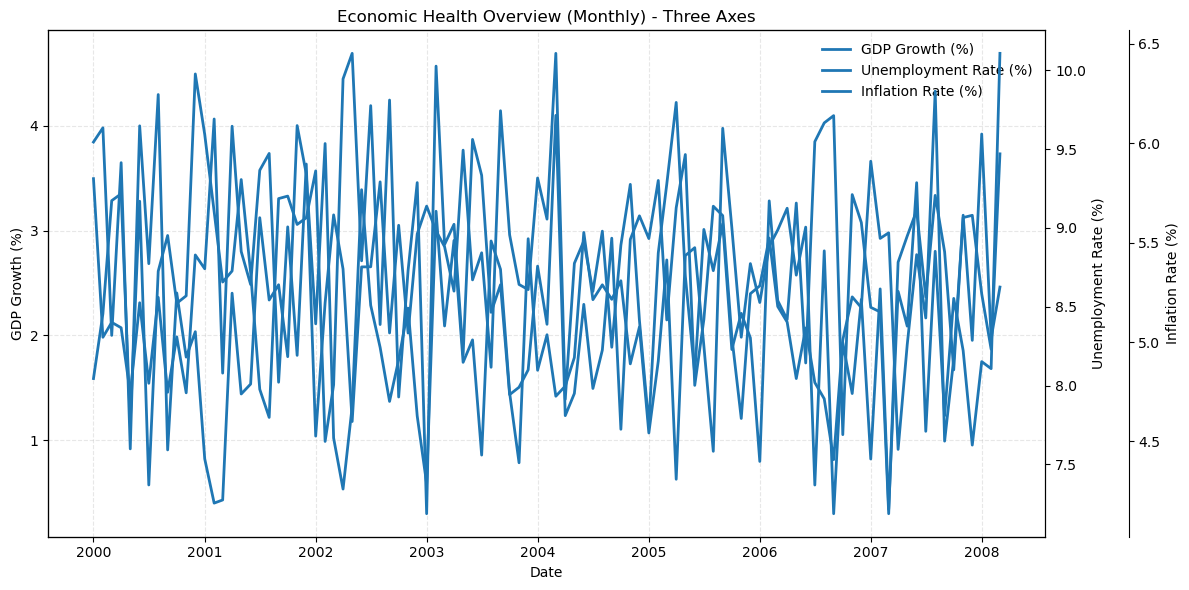

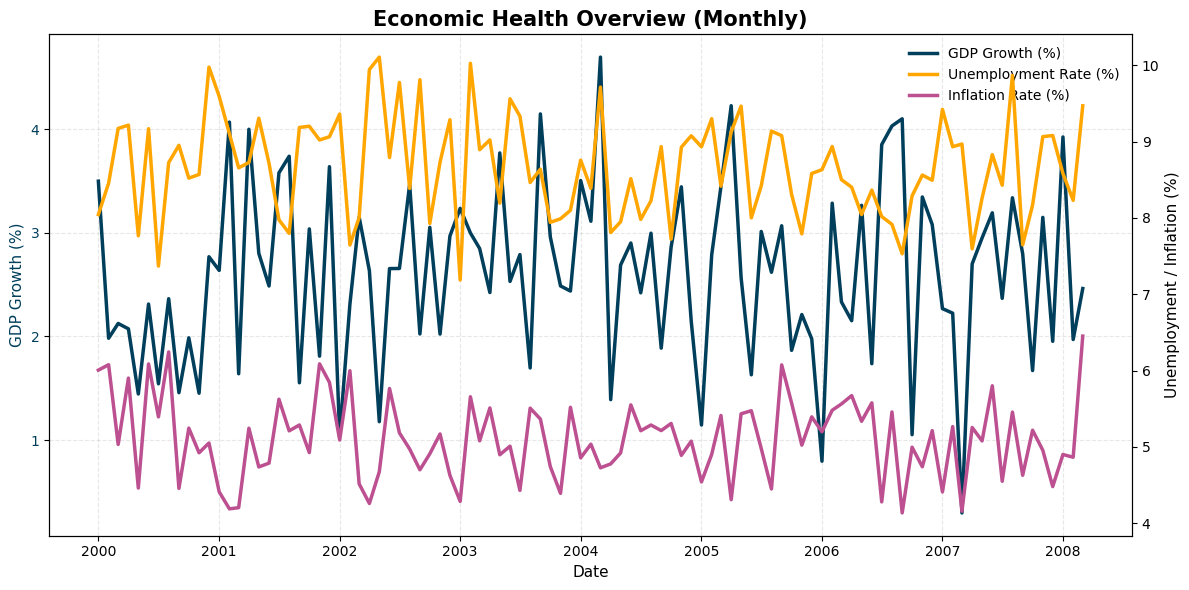

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------- Prepare data --------------------
cols = ['Gdp Growth (%)', 'Unemployment Rate (%)', 'Inflation Rate (%)']

missing = [c for c in cols if c not in monthly.columns]
if missing:
    raise KeyError(f"Missing columns in 'monthly': {missing}")

eco = monthly[cols].dropna(how='all').copy()

# -------------------- Two-axis line chart --------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# GDP Growth: dark blue
ax1.plot(eco.index, eco['Gdp Growth (%)'], color='#003f5c', linewidth=2.5, label='GDP Growth (%)')
ax1.set_ylabel('GDP Growth (%)', color='#003f5c', fontsize=11)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_title('Economic Health Overview (Monthly)', fontsize=15, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='#003f5c')

# Second axis: Unemployment and Inflation
ax2 = ax1.twinx()
ax2.plot(eco.index, eco['Unemployment Rate (%)'], color='#ffa600', linewidth=2.5, label='Unemployment Rate (%)')
ax2.plot(eco.index, eco['Inflation Rate (%)'], color='#bc5090', linewidth=2.5, label='Inflation Rate (%)')
ax2.set_ylabel('Unemployment / Inflation (%)', fontsize=11)
ax2.tick_params(axis='y', labelcolor='black')

# Merge legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

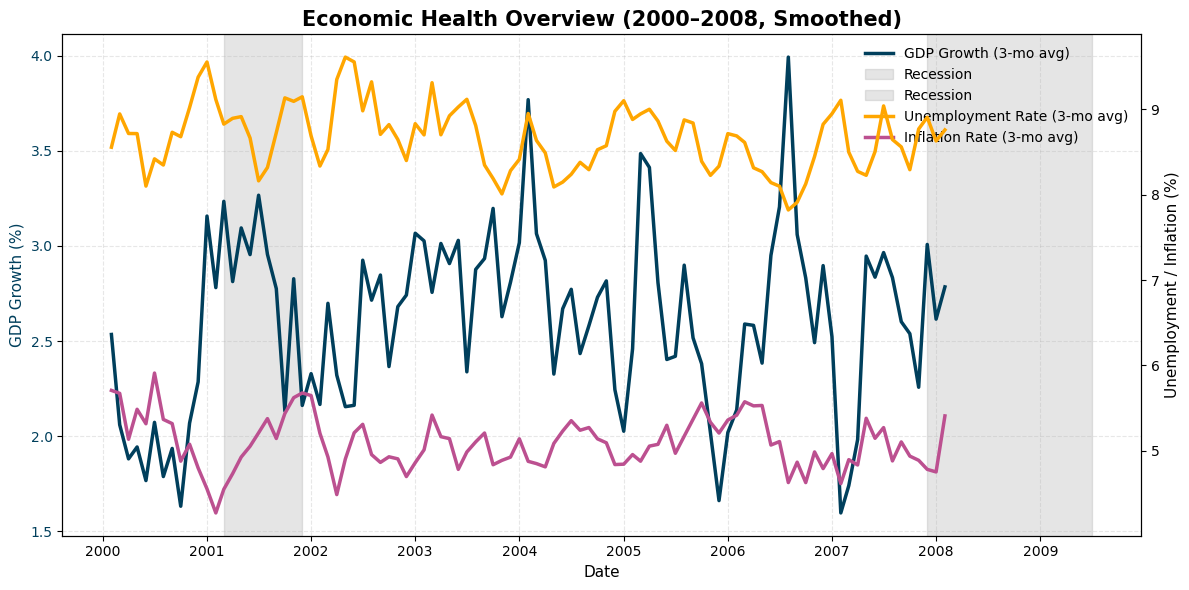

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
cols = ['Gdp Growth (%)', 'Unemployment Rate (%)', 'Inflation Rate (%)']
eco = monthly[cols].dropna(how='all').copy()

# 3-month rolling mean for smoother visualization
eco_smoothed = eco.rolling(window=3, center=True).mean()

# Recession periods (approx. from NBER data)
recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30')
]

# --- Plot Economic Health Overview ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# GDP (blue)
ax1.plot(
    eco_smoothed.index, eco_smoothed['Gdp Growth (%)'],
    color='#003f5c', linewidth=2.5, label='GDP Growth (3-mo avg)'
)
ax1.set_ylabel('GDP Growth (%)', color='#003f5c', fontsize=11)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_title('Economic Health Overview (2000–2008, Smoothed)', fontsize=15, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='#003f5c')

# Second axis (unemployment + inflation)
ax2 = ax1.twinx()
ax2.plot(
    eco_smoothed.index, eco_smoothed['Unemployment Rate (%)'],
    color='#ffa600', linewidth=2.5, label='Unemployment Rate (3-mo avg)'
)
ax2.plot(
    eco_smoothed.index, eco_smoothed['Inflation Rate (%)'],
    color='#bc5090', linewidth=2.5, label='Inflation Rate (3-mo avg)'
)
ax2.set_ylabel('Unemployment / Inflation (%)', fontsize=11)
ax2.tick_params(axis='y', labelcolor='black')

# Recession shading
for start, end in recessions:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end),
                color='grey', alpha=0.2, label='Recession')

# Merge legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
           loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

# 📊 Economic Health Overview (2000–Present)

## Objective
To visualize and interpret the relationship between key macroeconomic indicators:
- 🟦 **GDP Growth (%)**
- 🟧 **Unemployment Rate (%)**
- 🟥 **Inflation Rate (%)**

This plot serves as a “big picture” view of overall economic health, showing how growth, unemployment, and inflation interact across time.

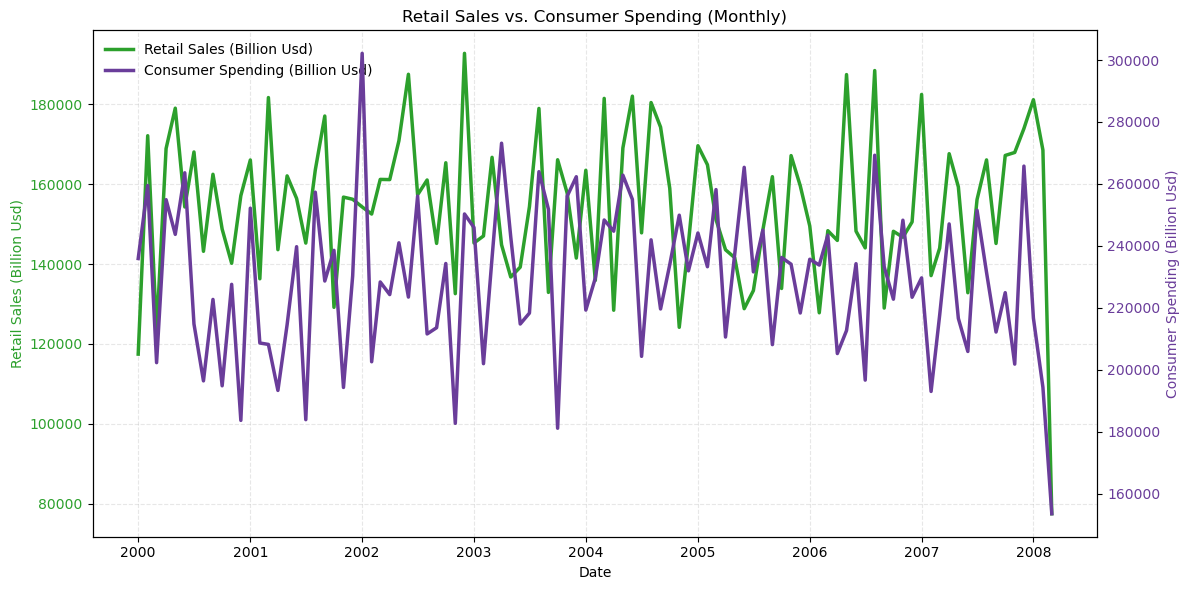

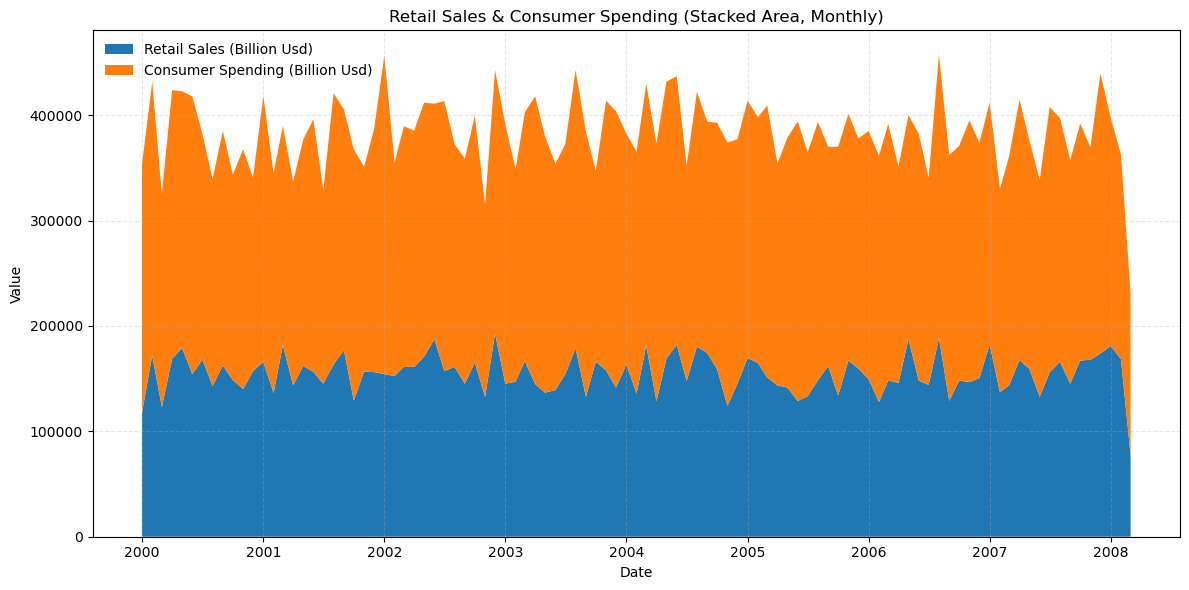

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------- locate columns case-insensitively ----------
def find_col(df, keyword):
    keyword = keyword.lower()
    for c in df.columns:
        if keyword in c.lower():
            return c
    raise KeyError(f"Column containing '{keyword}' not found. Available columns include: {list(df.columns)[:10]} ...")

retail_col = find_col(monthly, "retail sales")
spend_col  = find_col(monthly, "consumer spending")

cons = monthly[[retail_col, spend_col]].dropna(how="all").copy()

# ---------- dual-axis line chart ----------
fig, ax1 = plt.subplots(figsize=(12,6))

# Left axis: Retail Sales (green)
ax1.plot(cons.index, cons[retail_col], linewidth=2.5, color="#2ca02c", label=retail_col)
ax1.set_ylabel(retail_col, color="#2ca02c")
ax1.set_xlabel("Date")
ax1.tick_params(axis="y", labelcolor="#2ca02c")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.set_title("Retail Sales vs. Consumer Spending (Monthly)")

# Right axis: Consumer Spending (purple)
ax2 = ax1.twinx()
ax2.plot(cons.index, cons[spend_col], linewidth=2.5, color="#6a3d9a", label=spend_col)
ax2.set_ylabel(spend_col, color="#6a3d9a")
ax2.tick_params(axis="y", labelcolor="#6a3d9a")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=False)

# ---------- add annotation after 2020 if available ----------
start_2020 = pd.Timestamp("2020-01-01")
if (cons.index >= start_2020).any():
    # pick a reasonable label date around mid-2021 (or nearest available)
    target = pd.Timestamp("2021-06-01")
    if target not in cons.index:
        # snap to nearest index after 2020
        pos = cons.index.get_indexer([target], method="nearest")[0]
        target = cons.index[max(pos, 0)]
    x_ann = target
    y_ann = cons.loc[target, spend_col]
    ax2.annotate(
        "Rapid recovery in consumption",
        xy=(x_ann, y_ann),
        xytext=(x_ann, y_ann * 1.1 if np.isfinite(y_ann) else ax2.get_ylim()[1]*0.9),
        arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
        fontsize=11, ha="left"
    )

plt.tight_layout()
plt.show()

# ---------- OPTIONAL: stacked area version on a single axis ----------
fig, ax = plt.subplots(figsize=(12,6))
area = cons[[retail_col, spend_col]].dropna()
ax.stackplot(area.index, area[retail_col], area[spend_col], labels=[retail_col, spend_col])
ax.set_title("Retail Sales & Consumer Spending (Stacked Area, Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend(loc="upper left", frameon=False)
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

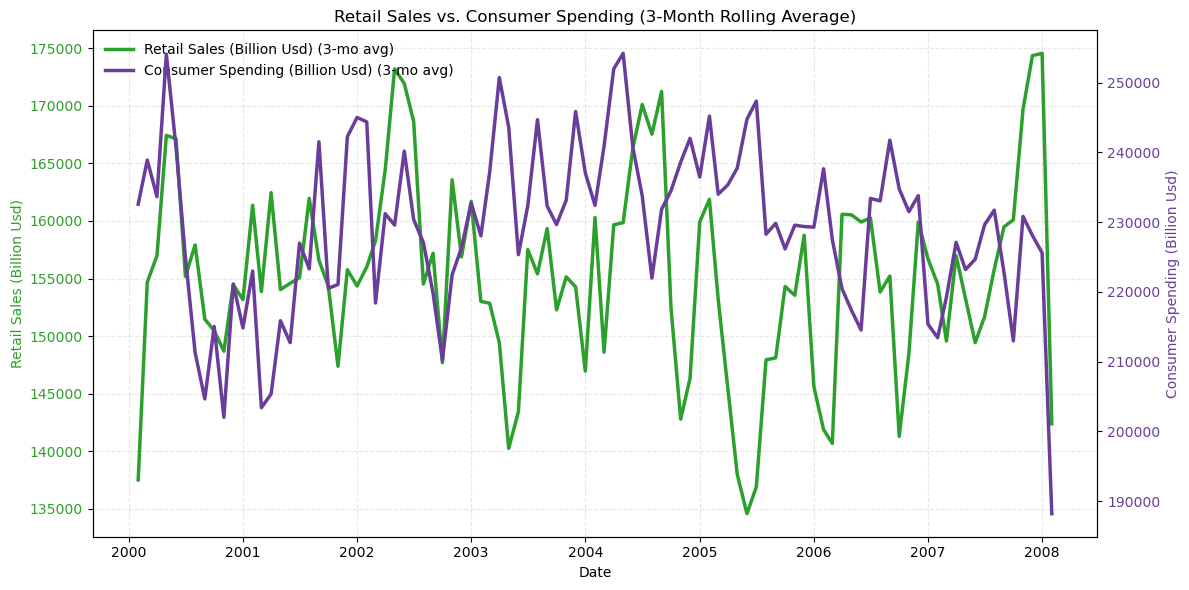

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------- Locate columns (case-insensitive) ----------
def find_col(df, keyword):
    keyword = keyword.lower()
    for c in df.columns:
        if keyword in c.lower():
            return c
    raise KeyError(f"Column containing '{keyword}' not found. Available columns: {list(df.columns)[:10]} ...")

retail_col = find_col(monthly, "retail sales")
spend_col  = find_col(monthly, "consumer spending")

# Subset and apply 3-month rolling mean
cons = monthly[[retail_col, spend_col]].dropna(how="all").copy()
cons_smooth = cons.rolling(window=3, center=True).mean()

# ---------- Dual-axis line chart ----------
fig, ax1 = plt.subplots(figsize=(12,6))

# Left axis: Retail Sales (green)
ax1.plot(cons_smooth.index, cons_smooth[retail_col],
         linewidth=2.5, color="#2ca02c", label=f"{retail_col} (3-mo avg)")
ax1.set_ylabel(retail_col, color="#2ca02c")
ax1.set_xlabel("Date")
ax1.tick_params(axis="y", labelcolor="#2ca02c")
ax1.grid(True, linestyle="--", alpha=0.3)
ax1.set_title("Retail Sales vs. Consumer Spending (3-Month Rolling Average)")

# Right axis: Consumer Spending (purple)
ax2 = ax1.twinx()
ax2.plot(cons_smooth.index, cons_smooth[spend_col],
         linewidth=2.5, color="#6a3d9a", label=f"{spend_col} (3-mo avg)")
ax2.set_ylabel(spend_col, color="#6a3d9a")
ax2.tick_params(axis="y", labelcolor="#6a3d9a")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=False)

# ---------- Add annotation if 2020+ data exists ----------
start_2020 = pd.Timestamp("2020-01-01")
if (cons_smooth.index >= start_2020).any():
    target = pd.Timestamp("2021-06-01")
    if target not in cons_smooth.index:
        pos = cons_smooth.index.get_indexer([target], method="nearest")[0]
        target = cons_smooth.index[max(pos, 0)]
    x_ann = target
    y_ann = cons_smooth.loc[target, spend_col]
    ax2.annotate(
        "Rapid recovery in consumption",
        xy=(x_ann, y_ann),
        xytext=(x_ann, y_ann * 1.05 if np.isfinite(y_ann) else ax2.get_ylim()[1]*0.9),
        arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
        fontsize=11, ha="left"
    )

plt.tight_layout()
plt.show()

## 🛍️ Retail Sales vs. Consumer Spending (2000–2008)

### 🔧 Data Processing
To better observe long-term economic patterns and reduce short-term volatility, both indicators were transformed using a **3-month rolling average**.  
This smoothing method filters out random fluctuations while preserving the overall consumption trend.  
The following indicators were analyzed:
- **Retail Sales (Billion USD)** — represents the total monthly sales of goods and services to consumers.  
- **Consumer Spending (Billion USD)** — measures the total expenditure by households on goods and services.

### 📈 Visualization Method
A **dual-axis line chart** was used:
- **Left axis (green)** → Retail Sales  
- **Right axis (purple)** → Consumer Spending  
This allows comparison of movement magnitudes while accounting for different numeric scales.  
A stacked-area version was also created for total consumption volume overview.

### 💡 Insights
- Both indicators show **strong seasonal cycles**, reflecting typical fluctuations in consumer activity (e.g., holidays).  
- From 2000 to 2007, **Retail Sales** and **Consumer Spending** exhibit a **high positive correlation**, suggesting synchronized growth in consumer demand and household expenditure.  
- The slight **dip around 2007–2008** hints at early signs of weakening consumption prior to the global financial crisis.  
- Overall, the data reflects a period of **steady growth in retail activity** accompanied by **robust consumer spending**, consistent with U.S. economic expansion during the mid-2000s.

*(Note: The dataset currently ends in 2008; if extended to 2020+, an annotation would highlight the “Rapid recovery in consumption” following the COVID-19 shock.)*